In [4]:
# gst-launch-1.0 nvarguscamerasrc sensor_mode=0 num-buffers=1 ! 'video/x-raw(memory:NVMM),width=3264, height=2464, framerate=21/1, format=NV12' ! nvvidconv flip-method=2 ! nvjpegenc ! filesink location=test_full.jpg
# gst-launch-1.0 nvarguscamerasrc sensor_mode=0 num-buffers=1 ! 'video/x-raw(memory:NVMM),width=1920, height=1080, framerate=21/1, format=NV12' ! nvvidconv flip-method=2 ! nvjpegenc ! filesink location=test_1080p.jpg
# gst-launch-1.0 nvarguscamerasrc sensor_mode=0 num-buffers=1 ! 'video/x-raw(memory:NVMM),width=1280, height=720, framerate=21/1, format=NV12' ! nvvidconv flip-method=2 ! nvjpegenc ! filesink location=test_720p.jpg


# gst-launch-1.0 nvarguscamerasrc sensor_mode=0 num-buffers=1 ! 'video/x-raw(memory:NVMM),width=1280, height=720, framerate=21/1, format=NV12' ! nvvidconv flip-method=2  ! 'video/x-raw,width=1440, height=1080' ! nvjpegenc ! filesink location=test_1080_4by3.jpg
# gst-launch-1.0 v4l2src device=/dev/video1 num-buffers=1 ! video/x-raw,format=UYVY ! videoscale ! video/x-raw,width=3264,height=2464 ! nvjpegenc ! filesink location=test_ir.jpg


# Capture IR and RGB images


In [442]:
from PIL import Image
import matplotlib.pyplot as plt


def get_ir_image():
    # save to png to preserve the 16 bit depth of IR image
    # !gst-launch-1.0 v4l2src device=/dev/video1 num-buffers=1 ! video/x-raw,format=GRAY8 ! videoscale ! video/x-raw,width=800,height=600 ! videoconvert ! pngenc ! filesink location=/tmp/ir.png
    # !gst-launch-1.0 v4l2src device=/dev/video1 num-buffers=1 ! video/x-raw,format=GRAY16_LE ! videoscale ! video/x-raw,width=800,height=600 ! videoconvert ! pngenc ! filesink location=/tmp/ir.png
    !gst-launch-1.0 v4l2src device=/dev/video1 num-buffers=1 ! video/x-raw,format=GRAY16_LE ! videoconvert ! pngenc ! filesink location=/tmp/ir.png

    return Image.open("/tmp/ir.png")

def get_rgb_image():
    !gst-launch-1.0 nvarguscamerasrc sensor_mode=0 num-buffers=15 ! 'video/x-raw(memory:NVMM),width=3264, height=2464, framerate=21/1, format=NV12' ! nvvidconv flip-method=2 ! nvjpegenc ! filesink location=/tmp/rgb.jpg
    return Image.open("/tmp/rgb.jpg")

def ktoc(val):
    # Kelvin to Celsius
    return (val - 27315) / 100.0

In [443]:
ir = get_ir_image()
rgb = get_rgb_image()

Setting pipeline to PAUSED ...
Pipeline is live and does not need PREROLL ...
Setting pipeline to PLAYING ...
New clock: GstSystemClock
Got EOS from element "pipeline0".
Execution ended after 0:00:02.768548605
Setting pipeline to PAUSED ...
Setting pipeline to READY ...
Setting pipeline to NULL ...
Freeing pipeline ...
Setting pipeline to PAUSED ...
Pipeline is live and does not need PREROLL ...
Setting pipeline to PLAYING ...
New clock: GstSystemClock
GST_ARGUS: Creating output stream
CONSUMER: Waiting until producer is connected...
GST_ARGUS: Available Sensor modes :
GST_ARGUS: 3264 x 2464 FR = 21.000000 fps Duration = 47619048 ; Analog Gain range min 1.000000, max 10.625000; Exposure Range min 13000, max 683709000;

GST_ARGUS: 3264 x 1848 FR = 28.000001 fps Duration = 35714284 ; Analog Gain range min 1.000000, max 10.625000; Exposure Range min 13000, max 683709000;

GST_ARGUS: 1920 x 1080 FR = 29.999999 fps Duration = 33333334 ; Analog Gain range min 1.000000, max 10.625000; Exposur

In [444]:
ir_arr = np.array(ir)[:-2, :] # trim the 2 bottom lines
ir_arr = cv2.resize(ktoc(ir_arr), (1024, 768))
ir_arr_normalized = cv2.normalize(ir_arr.astype(np.int32), None, 0, 255, cv2.NORM_MINMAX) # deg. C to 0-255

In [445]:
rgb_arr = np.array(rgb)
rgb_arr = cv2.resize(rgb_arr, (1024, 768))
rgb_arr = cv2.cvtColor(rgb_arr, cv2.COLOR_BGR2GRAY)

In [456]:
T = np.array(
    [
        [1.1, 0.0, 0.0],
        [0.0, 1.1, -10.0],
#         [0,0,1.0]
    ]

)

rgb_arr_shifted = cv2.warpAffine(
    rgb_arr,
    T,
    (rgb_arr.shape[1],
     rgb_arr.shape[0])
)

to_show = np.stack([rgb_arr_shifted*2, ir_arr_normalized//5, np.zeros_like(rgb_arr)], axis=-1)

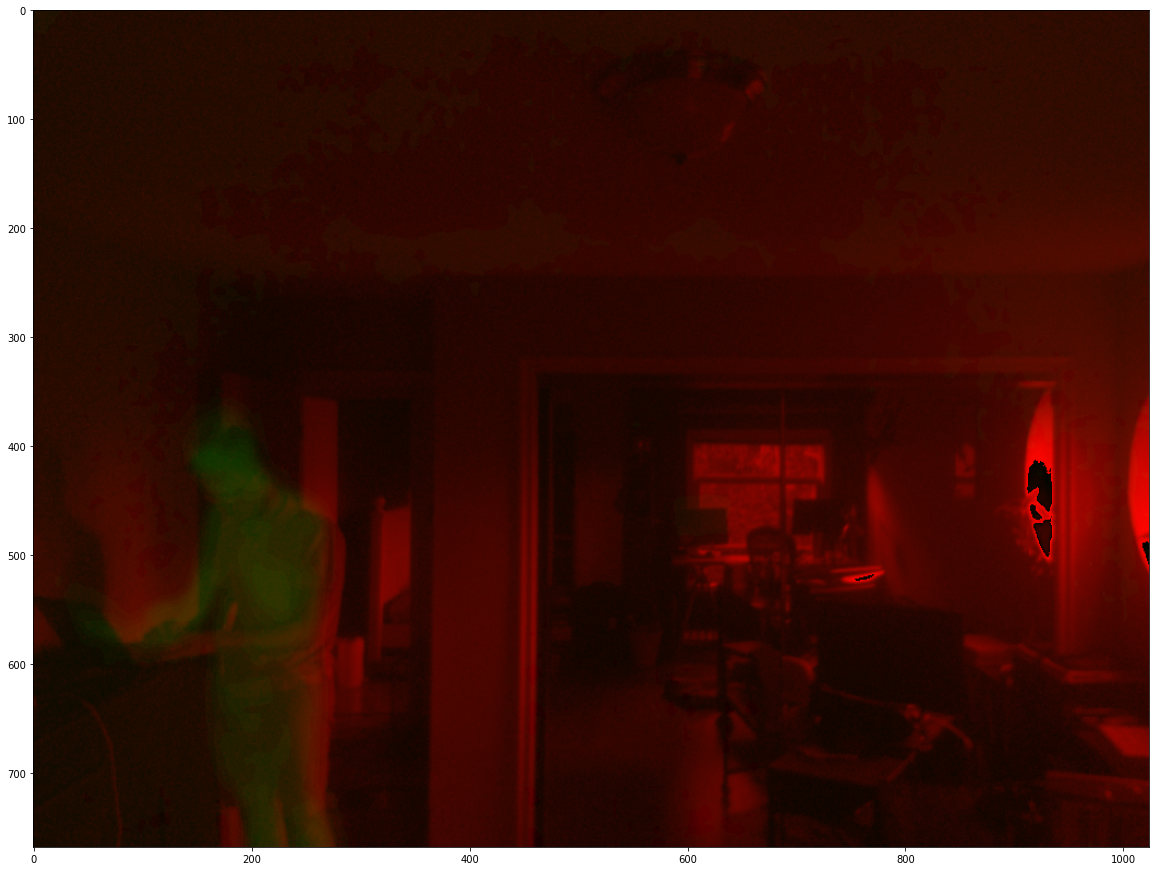

In [457]:
plt.figure(figsize=(20,20))
plt.imshow(to_show)

In [340]:
image = rgb_arr
  
# Store height and width of the image 
height, width = image.shape[:2] 
  
quarter_height, quarter_width = height / 4, width / 4
  
T = np.float32([[1, 0, 100], [0, 1, 0]]) 
  
# We use warpAffine to transform 
# the image using the matrix, T 
img_translation = cv2.warpAffine(image, T, (width, height))


# image
# cv2.imshow("Originalimage", image) 
# cv2.imshow('Translation', img_translation) 
# cv2.waitKey()

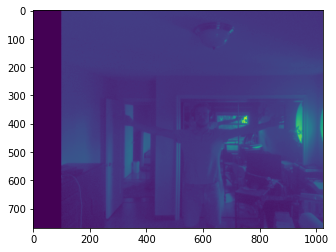

In [341]:
plt.imshow(img_translation)

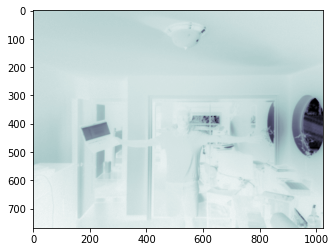

In [268]:
plt.imshow(rgb_arr, cmap='bone_r')

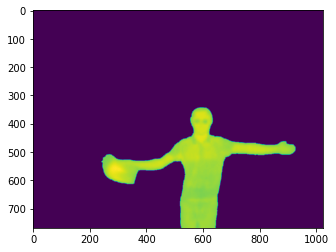

In [245]:
s = np.array(ir_arr, copy=True)
s[s<30] = 0
plt.imshow(s)

In [26]:
# Initiate AKAZE detector
akaze = cv2.AKAZE_create()
# Find the keypoints and descriptors with SIFT
kp1, des1 = akaze.detectAndCompute(img1, None)
kp2, des2 = akaze.detectAndCompute(img2, None)


In [33]:
# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# Apply ratio test
good_matches = []
for m,n in matches:
    if m.distance < 0.9 * n.distance:
        good_matches.append([m])
        
# Draw matches
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good_matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
cv2.imwrite('matches.jpg', img3)

True

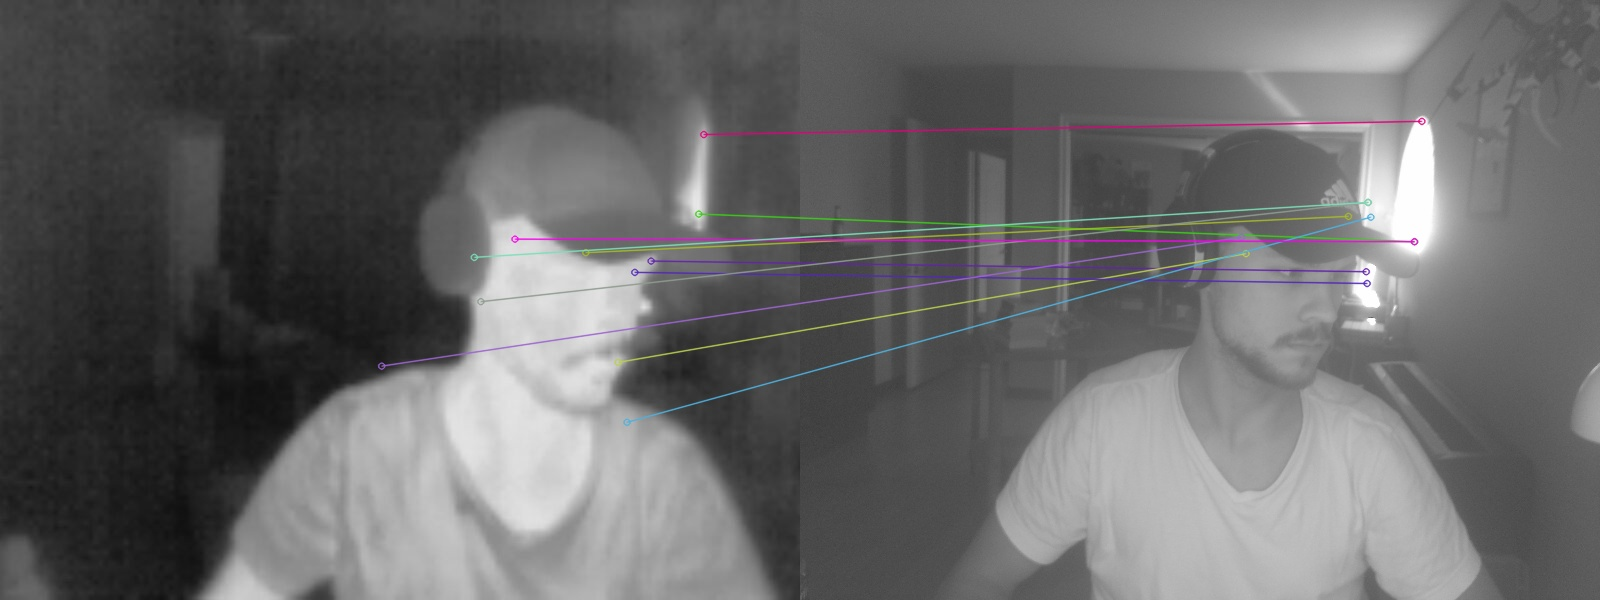

In [34]:
Image.open('matches.jpg')